# Implementação teste

In [1]:
!pip install pymc3

Defaulting to user installation because normal site-packages is not writeable


### Imports

In [4]:
%matplotlib inline
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano

plt.style.use('seaborn-darkgrid')

Modelo que usaremos para modelar a morte de um idioma:

In [7]:
def SIR(y, t, p):
    dt = (1 - y[0])*p[0]*p[1]*(y[0])**p[2] + y[0]*p[0]*(1-p[1])*(1-y[0])**p[2]
    return [dt]

Testando com dados ficticios (os parametros foram chutados):

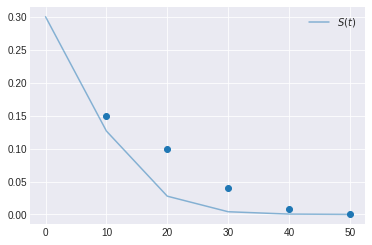

In [8]:
times = np.arange(0, 60, 10)


# Gerando curvas simuladas
y = odeint(SIR, y0=[0.30], t=times, args=((-1, 0.8, 4),), rtol=1e-8) # argumentos chutados
# dados (nesse caso ficticios)
yobs = np.array([[0.15], [0.10], [0.04], [0.009], [0.001]])

plt.plot(times[1::], yobs, marker='o', linestyle='none')
plt.plot(times, y[:], color='C0', alpha=0.5, label=f'$S(t)$')
plt.legend();

Definição do modelo:

In [9]:
sir_model = DifferentialEquation(
    func=SIR,
    times=np.arange(10, 60, 10),
    n_states=1,
    n_theta=3,
    t0=0,
)

Estimação dos parametro (c, s e a):

In [ ]:
with pm.Model() as model4:
    sigma = pm.HalfCauchy('sigma', 1, shape=1)

    # Distribuições a priori (lower liminf, upper limsup)
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3)
    c = pm.Uniform('c', -6, 0)
    s = pm.Uniform('s', 0, 1)
    a = pm.Uniform('a', 0, 10)
    
    sir_curves = sir_model(y0=[0.30], theta=[c, s, a])

    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sigma=sigma, observed=yobs)
#    db = pm.backends.HDF5('traces.h5') # Salva as amostras e assim evita de manter tudo na memória
    trace = pm.sample(3000, tune=1500, start={'R0': np.array(2), 'c': np.array(-0.2), 'sigma': np.array([1]), 's': np.array(0.5), 'a': np.array(1.31)})

/tmp/ipykernel_3861/2200293824.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(3000, tune=1500, start={'R0': np.array(2), 'c': np.array(-0.2), 'sigma': np.array([1]), 's': np.array(0.5), 'a': np.array(1.31)})
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, s, c, R0, sigma]


/usr/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2873954238208D+02   r2 =                  NaN


/usr/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2162285066403D+01   r2 =                  NaN


/usr/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2998283006724D+02   r2 =                  NaN


Dados da estimação dos parametros:

In [ ]:
data = az.from_pymc3(trace=trace)
data

Posteriori dos parametros

In [ ]:
az.plot_posterior(data, round_to=2, hdi_prob=0.95);

Modelagem do idioma ficticio

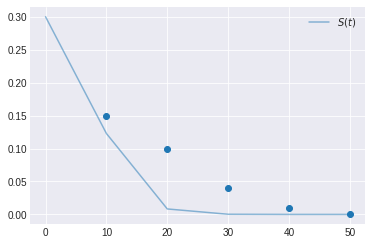

In [13]:
y = odeint(SIR, y0=[0.30], t=times, args=((-0.99, 0.64, 5.9),), rtol=1e-8) # parametros da porteriori

plt.plot(times[1::], yobs, marker='o', linestyle='none')
plt.plot(times, y[:], color='C0', alpha=0.5, label=f'$S(t)$')
plt.legend();